In [ ]:
from torchvision.datasets import OxfordIIITPet
import torch

In [ ]:
from torchvision.transforms import ToTensor,Resize
from torchvision import transforms

custom_transform = transforms.Compose([
    Resize((224,224)),
    ToTensor()
])

In [ ]:
dataset = OxfordIIITPet(root='data', download=True, transform=custom_transform)
len(dataset)

3680

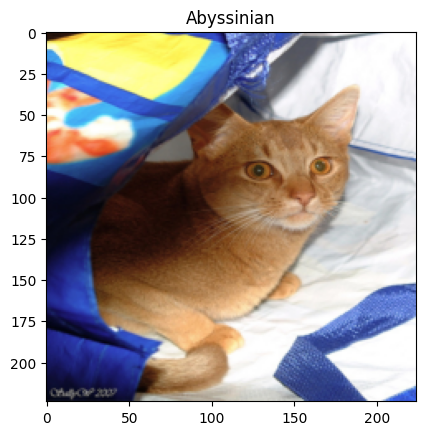

In [ ]:
from matplotlib import pyplot as plt
image,label = dataset[0]

plt.imshow(image.permute(1,2,0))
plt.title(dataset.classes[label])
plt.show()

In [ ]:
from torch.utils.data import DataLoader,random_split
import math

train_size = math.floor(0.8 * len(dataset))
test_size = len(dataset) - train_size
val_size = test_size//2
test_size -= val_size

train_dataset,test_dataset,val_dataset = random_split(dataset,[train_size,test_size,val_size])

train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=32,shuffle=False)
val_dataloader = DataLoader(val_dataset,batch_size=32,shuffle=False)

# Vision Transformer

## Architecture

![vision transformer architecture](https://www.pinecone.io/_next/image/?url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fvr8gru94%2Fproduction%2Fef2026fc131e20c7fb0b0298ab88d5e365339514-4009x1821.png&w=3840&q=75)

source:https://www.pinecone.io/learn/series/image-search/vision-transformers/


### Step one Turning images to patches

* input_image = H * W * C
* H = image height
* W = image width
* C = color channels
* output = N*(P<sup>2</sup>)*C
* P = Patch size
* N = (H * W )/(P<sup>2</sup>)


In [ ]:
C,H,W = dataset[0][0].shape
C,H,W

(3, 224, 224)

In [ ]:
P = 16
N = (H*W)//(P**2)
N

196

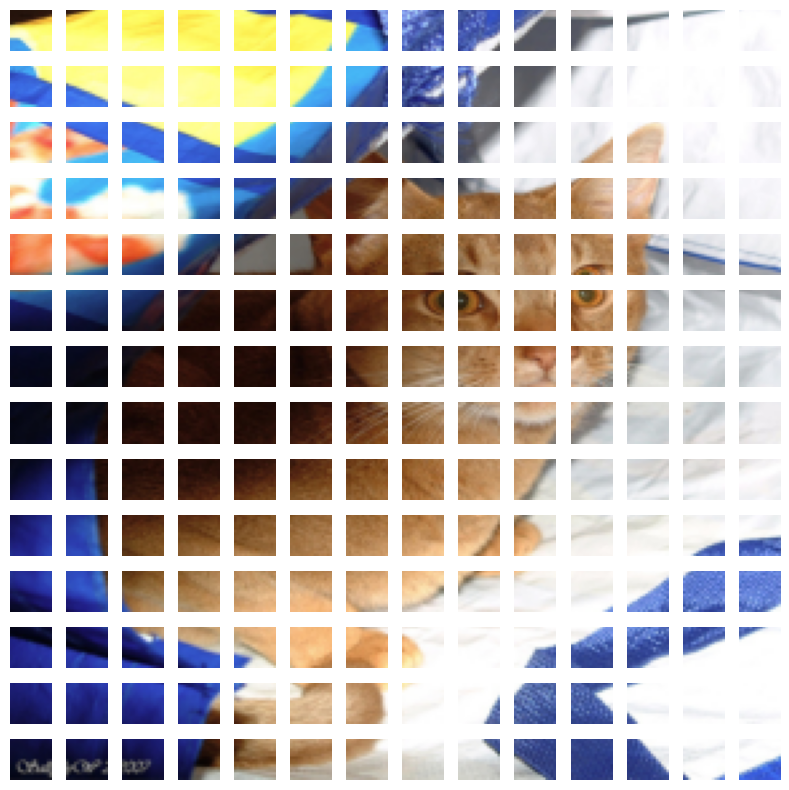

In [ ]:
fig,axes = plt.subplots(nrows=H//P,ncols=W//P,figsize=(P/2, P/2))
image = image.permute(1,2,0)
for i ,r_patch in enumerate(range(0,H,P)):
    for j , c_patch in enumerate(range(0,W,P)):
        axes[i,j].imshow(image[r_patch:r_patch+P,c_patch:c_patch+P,:])
        axes[i,j].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
convo_layer = torch.nn.Conv2d(in_channels=3,out_channels=124,kernel_size=P,stride=P,padding=0,bias=False)

In [ ]:
result = convo_layer(image.permute(2,1,0).unsqueeze(0))
result.shape

torch.Size([1, 124, 14, 14])

In [ ]:
flatten_layer = torch.nn.Flatten(start_dim=2)
flatten_layer(result).shape

torch.Size([1, 124, 196])

## Making patch embedding module

In [ ]:
class PatchEmbedding(torch.nn.Module):
  def __init__(self,input=3,emb_dim=124,patch=16) -> None:
     super().__init__()
     self.patch = patch
     self.convo_layer = torch.nn.Conv2d(in_channels=input,out_channels=emb_dim,kernel_size=patch,stride=patch,padding=0,bias=False)
     self.flatten_layer = torch.nn.Flatten(start_dim=2)

  def forward(self,x):
    _,c,h,w = x.shape
    assert h % self.patch == 0 and w % self.patch == 0, f"Wrong image shape"
    x = self.convo_layer(x)
    x = self.flatten_layer(x)
    return x.permute(0,2,1)


In [ ]:
patch_embedding = PatchEmbedding()
patch_embedding(image.permute(2,0,1).unsqueeze(0)).shape

torch.Size([1, 196, 124])

## Creating class token embedding

In [ ]:
cls = torch.nn.Parameter(torch.randn((1,1,124),requires_grad=True))

In [ ]:
torch.concat([cls,patch_embedding(image.permute(2,0,1).unsqueeze(0))],dim=1)

tensor([[[-1.8712,  0.8409, -1.6922,  ..., -0.8461,  0.1652,  0.4648],
         [-0.1001, -0.3333,  0.6893,  ...,  0.2769,  0.4640, -0.0262],
         [-0.1330,  0.0221,  0.4866,  ...,  0.3704,  0.0664,  0.1033],
         ...,
         [ 0.0998, -0.0212,  0.5138,  ..., -0.0431,  0.0801, -0.1414],
         [ 0.0284,  0.0464,  0.8157,  ..., -0.0068,  0.3864,  0.0297],
         [ 0.3626, -0.0814,  0.5427,  ..., -0.0584,  0.4150,  0.1790]]],
       grad_fn=<CatBackward0>)

## Positional Embedding



### Positional Encoding Formula

- ### PE<sub>(pos,2i)</sub> = sin(pos/10000<sup>2i/dim_model</sup>)
- ### PE<sub>(pos,2i+1)</sub> = cos(pos/10000<sup>2i/dim_model</sup>)

### where

- i is i<sup>th</sup> dim from 0-(dim_model/2 - 1)
- pos is index from 0-(seq_length-1)
- dim_model is dimenstion of the model

### Example:

for i = 0,pos=0

2i=0,
2i+1=1

- PE<sub>(0,0)</sub> = sin(0/10000<sup>0/dim_model</sup>)
- PE<sub>(0,1)</sub> = cos(0/10000<sup>0/dim_model</sup>)


In [ ]:
class PositionalEmbedding(torch.nn.Module):
  def __init__(self,dim_model,seq_length,dropout=0.0) -> None:
    super().__init__()

    assert dim_model % 2 == 0, "dim_model must be even"

    self.dim_model = dim_model//2
    self.seq_length = seq_length

  def forward(self,x):

    pos = torch.arange(self.seq_length,dtype=torch.float).reshape(self.seq_length,1)
    depths = torch.arange(self.dim_model,dtype=torch.float).reshape(1,self.dim_model)

    pe = pos/torch.pow(10000,depths/self.dim_model)
    pe = torch.concat([torch.sin(pe),torch.cos(pe)],dim=1)

    return x + pe.unsqueeze(0).to(x.device)


In [ ]:
pe = PositionalEmbedding(124,196)
pe(patch_embedding(image.permute(2,0,1).unsqueeze(0))).shape

torch.Size([1, 196, 124])

In [ ]:
class ImageEmbedding(torch.nn.Module):
  def __init__(self,shape:tuple[int],input=3,emb_dim=124,patch=16) -> None:
    super().__init__()
    self.patch_embedding = PatchEmbedding(input,emb_dim,patch)
    self.cls = torch.nn.Parameter(torch.randn((1,1,emb_dim),requires_grad=True))
    self.emb_dim = emb_dim
    self.patch = patch
    assert (shape[0] * shape[1])/(patch**2) % 2 == 0, "Image size must be divisible by patch size"
    self.seq = (shape[0] * shape[1])//(patch**2)
    self.positional_embedding = PositionalEmbedding(emb_dim,self.seq+1)
    self.shape = shape

  def forward(self,x):
    batch_size = x.shape[0]
    x = self.patch_embedding(x)
    cls_tokens = self.cls.expand(batch_size, -1, -1)
    x = torch.concat([cls_tokens, x],dim=1)
    x = self.positional_embedding(x)
    return x

In [ ]:
ie = ImageEmbedding(shape=(224,224))
ie(image.permute(2,0,1).unsqueeze(0)).shape

torch.Size([1, 197, 124])

## Attention block

In [ ]:
class AttentionBlock(torch.nn.Module):
  def __init__(self,emb_dim,num_heads) -> None:
    super().__init__()
    self.emb_dim = emb_dim
    self.num_heads = num_heads
    assert emb_dim % num_heads == 0, "emb_dim must be divisible by num_heads"
    self.norm1 = torch.nn.LayerNorm(emb_dim)
    self.attention = torch.nn.MultiheadAttention(emb_dim,num_heads)


  def forward(self,x):
    x = x + self.attention(self.norm1(x),self.norm1(x),self.norm1(x))[0]
    return x


In [ ]:
atten_block = AttentionBlock(124,4)
att = atten_block(ie(image.permute(2,0,1).unsqueeze(0)))
att.shape

torch.Size([1, 197, 124])

## MLP BLOCK

In [ ]:
class MultiLayerPerceptron(torch.nn.Module):
  def __init__(self,emb_dim,mlp_dim,drop_out=0.1) -> None:
    super().__init__()
    self.normalize = torch.nn.LayerNorm(emb_dim)
    self.linear1 = torch.nn.Linear(emb_dim,mlp_dim)
    self.gelu = torch.nn.GELU()
    self.linear2 = torch.nn.Linear(mlp_dim,emb_dim)
    self.dropout = torch.nn.Dropout(drop_out)

  def forward(self,x):
    x = self.normalize(x)
    x = self.linear1(x)
    x = self.gelu(x)
    x = self.linear2(x)
    x = self.dropout(x)
    return x

In [ ]:
mlp = MultiLayerPerceptron(124,256)
mlp(att).shape

torch.Size([1, 197, 124])

## Encode Block

In [ ]:
class EncoderBlock(torch.nn.Module):
  def __init__(self,emb_dim=124,num_heads=4,mlp_dim=512,drop_out=0.1) -> None:
    super().__init__()
    self.attention = AttentionBlock(emb_dim,num_heads)
    self.mlp = MultiLayerPerceptron(emb_dim,mlp_dim,drop_out)

  def forward(self,x):
    x = self.attention(x)
    x = self.mlp(x)
    return x

In [ ]:
encoder_block = EncoderBlock()
encoder_block(ie(image.permute(2,0,1).unsqueeze(0))).shape

torch.Size([1, 197, 124])

# Transformer

In [ ]:
class VisionTransformer(torch.nn.Module):
  def __init__(self,shape:tuple[int],out,input=3,emb_dim=124,patch=16,num_heads=4,mlp_dim=512,drop_out=0.1,num_blocks=6) -> None:
    super().__init__()
    self.image_embedding = ImageEmbedding(shape,input,emb_dim,patch)
    self.encoder_blocks = torch.nn.Sequential(*[EncoderBlock(emb_dim,num_heads,mlp_dim,drop_out) for _ in range(num_blocks)])
    self.linear = torch.nn.Linear(emb_dim,out)
    self.norm = torch.nn.LayerNorm(emb_dim)

  def forward(self,x):
    x = self.image_embedding(x)
    x = self.encoder_blocks(x)
    x = self.norm(x)
    x = x[:,0,:]
    x = self.linear(x)
    return x

In [ ]:
vision_transformer = VisionTransformer(shape=(224,224),out=5)
vision_transformer(image.permute(2,0,1).unsqueeze(0)).shape

torch.Size([1, 5])

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

summary(vision_transformer,input_size=(1,3,224,224))


Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 5]                    --
├─ImageEmbedding: 1-1                         [1, 197, 124]             124
│    └─PatchEmbedding: 2-1                    [1, 196, 124]             --
│    │    └─Conv2d: 3-1                       [1, 124, 14, 14]          95,232
│    │    └─Flatten: 3-2                      [1, 124, 196]             --
│    └─PositionalEmbedding: 2-2               [1, 197, 124]             --
├─Sequential: 1-2                             [1, 197, 124]             --
│    └─EncoderBlock: 2-3                      [1, 197, 124]             --
│    │    └─AttentionBlock: 3-3               [1, 197, 124]             62,248
│    │    └─MultiLayerPerceptron: 3-4         [1, 197, 124]             127,860
│    └─EncoderBlock: 2-4                      [1, 197, 124]             --
│    │    └─AttentionBlock: 3-5               [1, 197, 124]             62,248
│ 

# Training

In [ ]:
model = VisionTransformer(shape=(224,224),out=len(dataset.classes),emb_dim=512,mlp_dim=1024)
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 37]                   --
├─ImageEmbedding: 1-1                         [1, 197, 512]             512
│    └─PatchEmbedding: 2-1                    [1, 196, 512]             --
│    │    └─Conv2d: 3-1                       [1, 512, 14, 14]          393,216
│    │    └─Flatten: 3-2                      [1, 512, 196]             --
│    └─PositionalEmbedding: 2-2               [1, 197, 512]             --
├─Sequential: 1-2                             [1, 197, 512]             --
│    └─EncoderBlock: 2-3                      [1, 197, 512]             --
│    │    └─AttentionBlock: 3-3               [1, 197, 512]             1,051,648
│    │    └─MultiLayerPerceptron: 3-4         [1, 197, 512]             1,051,136
│    └─EncoderBlock: 2-4                      [1, 197, 512]             --
│    │    └─AttentionBlock: 3-5               [1, 197, 512]             1,0

In [ ]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
def train(model,train,val,epoch,loss_fn,optimizer,device):
  train_loss = []
  val_loss = []
  train_accuray = []
  val_accuray = []
  for i in tqdm(range(epoch)):
    model.train()
    batch_train_loss = 0
    batch_val_loss = 0
    batch_train_accuray = 0
    batch_val_accuray = 0
    for x,y in train:
      x,y = x.to(device),y.to(device)
      optimizer.zero_grad()
      y_pred = model(x)
      loss = loss_fn(y_pred,y)
      loss.backward()
      optimizer.step()
      batch_train_loss += loss.item()
      batch_train_accuray += accuracy_score(y.cpu().detach().numpy(),y_pred.argmax(dim=-1).cpu().detach().numpy())

    train_loss.append(batch_train_loss/len(train))
    train_accuray.append(batch_train_accuray/len(train))

    model.eval()

    with torch.inference_mode():
      for x,y in val:
        x,y = x.to(device),y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred,y)
        batch_val_loss += loss.item()
        batch_val_accuray += accuracy_score(y.cpu().detach().numpy(),y_pred.argmax(dim=-1).cpu().detach().numpy())
      val_loss.append(batch_val_loss/len(val))
      val_accuray.append(batch_val_accuray/len(val))


    if i%2 == 0:
      print(f"Epoch: {i+1}")
      print(f"Train Loss: {train_loss[-1]:.4f} | Train Accuracy: {train_accuray[-1]:.4f}")
      print(f"Val Loss: {val_loss[-1]:.4f} | Val Accuracy: {val_accuray[-1]:.4f}")
      print("-"*50)

  return train_loss,val_loss,train_accuray,val_accuray


In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

train_loss,val_loss,train_accuracy,val_accuracy=train(model,train_dataloader,val_dataloader,50,loss,optimizer,device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 3.8301 | Train Accuracy: 0.0251
Val Loss: 3.7165 | Val Accuracy: 0.0326
--------------------------------------------------
Epoch: 3
Train Loss: 3.7141 | Train Accuracy: 0.0279
Val Loss: 3.6858 | Val Accuracy: 0.0272
--------------------------------------------------
Epoch: 5
Train Loss: 3.6767 | Train Accuracy: 0.0217
Val Loss: 3.6729 | Val Accuracy: 0.0272
--------------------------------------------------
Epoch: 7
Train Loss: 3.6680 | Train Accuracy: 0.0292
Val Loss: 3.6291 | Val Accuracy: 0.0380
--------------------------------------------------
Epoch: 9
Train Loss: 3.6491 | Train Accuracy: 0.0255
Val Loss: 3.6536 | Val Accuracy: 0.0245
--------------------------------------------------
Epoch: 11
Train Loss: 3.6477 | Train Accuracy: 0.0245
Val Loss: 3.6582 | Val Accuracy: 0.0163
--------------------------------------------------
Epoch: 13
Train Loss: 3.6397 | Train Accuracy: 0.0204
Val Loss: 3.6434 | Val Accuracy: 0.0272
-----------------------------------------

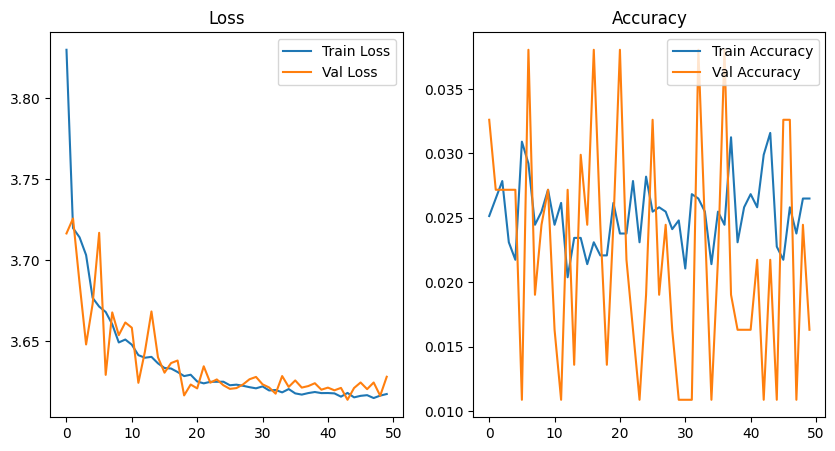

In [ ]:
import matplotlib.pyplot as plt
def plot(train_loss,val_loss,train_accuracy,val_accuracy):
  fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))

  ax[0].plot(train_loss,label='Train Loss')
  ax[0].plot(val_loss,label='Val Loss')
  ax[0].set_title('Loss')
  ax[0].legend()

  ax[1].plot(train_accuracy,label='Train Accuracy')
  ax[1].plot(val_accuracy,label='Val Accuracy')
  ax[1].set_title('Accuracy')
  ax[1].legend()

  plt.show()

plot(train_loss,val_loss,train_accuracy,val_accuracy)

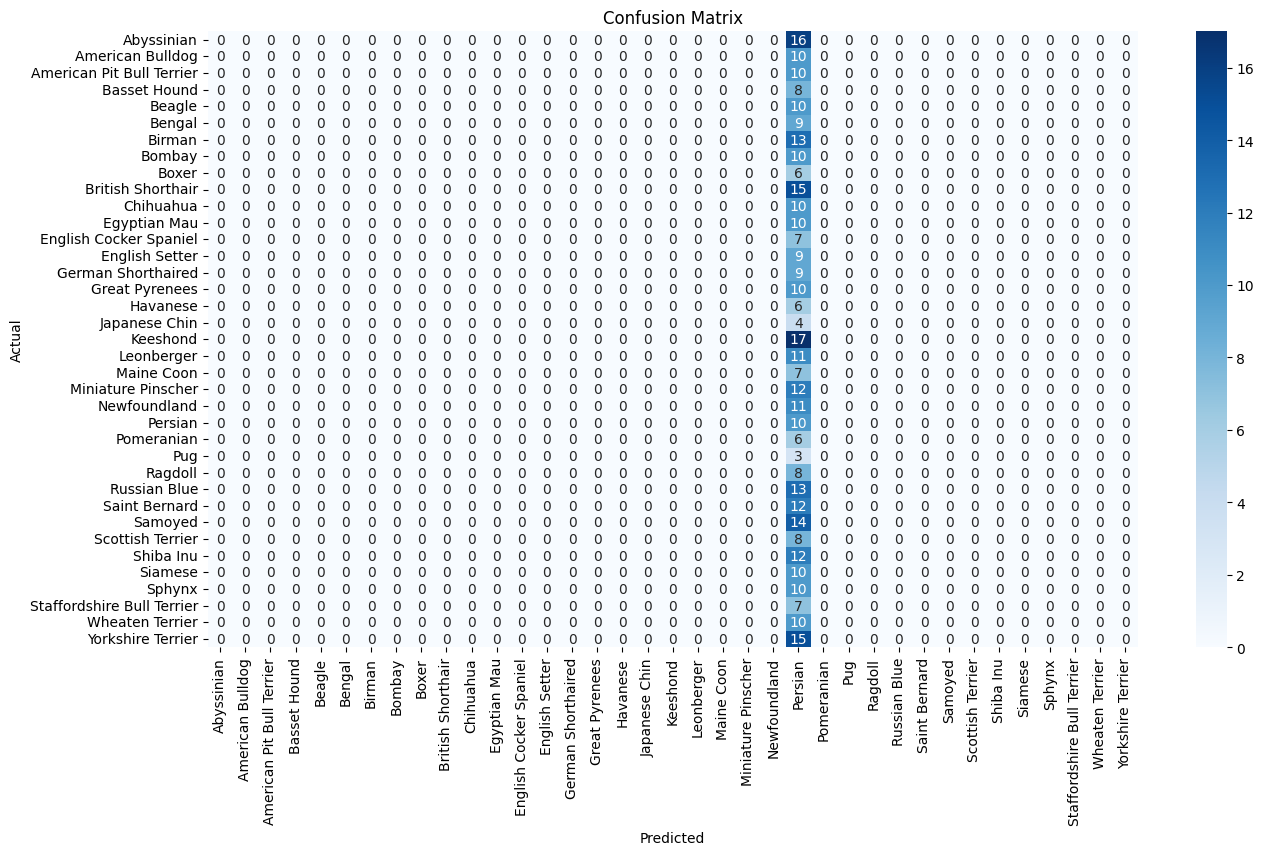

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
  for inputs, labels in test_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Using Pretrained

In [ ]:
import torch
import torchvision.models as models



weights = models.ViT_B_16_Weights.DEFAULT


model = models.vit_b_16(weights=weights)

summary(model,input_size=(1,3,224,224))


Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 1000]                 768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          590,592
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-7             

In [ ]:
for param in model.parameters():
  param.requires_grad = False

model.heads = torch.nn.Linear(768,len(dataset.classes))
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 37]                   768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          (590,592)
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
train_loss,val_loss,train_accuracy,val_accuracy=train(model,train_dataloader,val_dataloader,50,loss,optimizer,device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 1.4110 | Train Accuracy: 0.7456
Val Loss: 0.5214 | Val Accuracy: 0.8859
--------------------------------------------------
Epoch: 3
Train Loss: 0.2677 | Train Accuracy: 0.9436
Val Loss: 0.2703 | Val Accuracy: 0.9402
--------------------------------------------------
Epoch: 5
Train Loss: 0.1580 | Train Accuracy: 0.9718
Val Loss: 0.2254 | Val Accuracy: 0.9484
--------------------------------------------------
Epoch: 7
Train Loss: 0.1065 | Train Accuracy: 0.9857
Val Loss: 0.2093 | Val Accuracy: 0.9429
--------------------------------------------------
Epoch: 9
Train Loss: 0.0763 | Train Accuracy: 0.9922
Val Loss: 0.1889 | Val Accuracy: 0.9565
--------------------------------------------------
Epoch: 11
Train Loss: 0.0582 | Train Accuracy: 0.9956
Val Loss: 0.1781 | Val Accuracy: 0.9511
--------------------------------------------------
Epoch: 13
Train Loss: 0.0453 | Train Accuracy: 0.9983
Val Loss: 0.1731 | Val Accuracy: 0.9429
-----------------------------------------

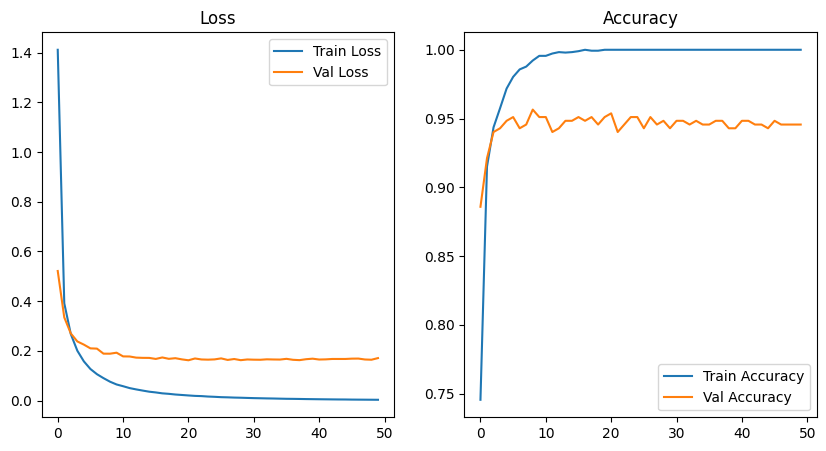

In [ ]:
import matplotlib.pyplot as plt
def plot(train_loss,val_loss,train_accuracy,val_accuracy):
  fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))

  ax[0].plot(train_loss,label='Train Loss')
  ax[0].plot(val_loss,label='Val Loss')
  ax[0].set_title('Loss')
  ax[0].legend()

  ax[1].plot(train_accuracy,label='Train Accuracy')
  ax[1].plot(val_accuracy,label='Val Accuracy')
  ax[1].set_title('Accuracy')
  ax[1].legend()

  plt.show()

plot(train_loss,val_loss,train_accuracy,val_accuracy)

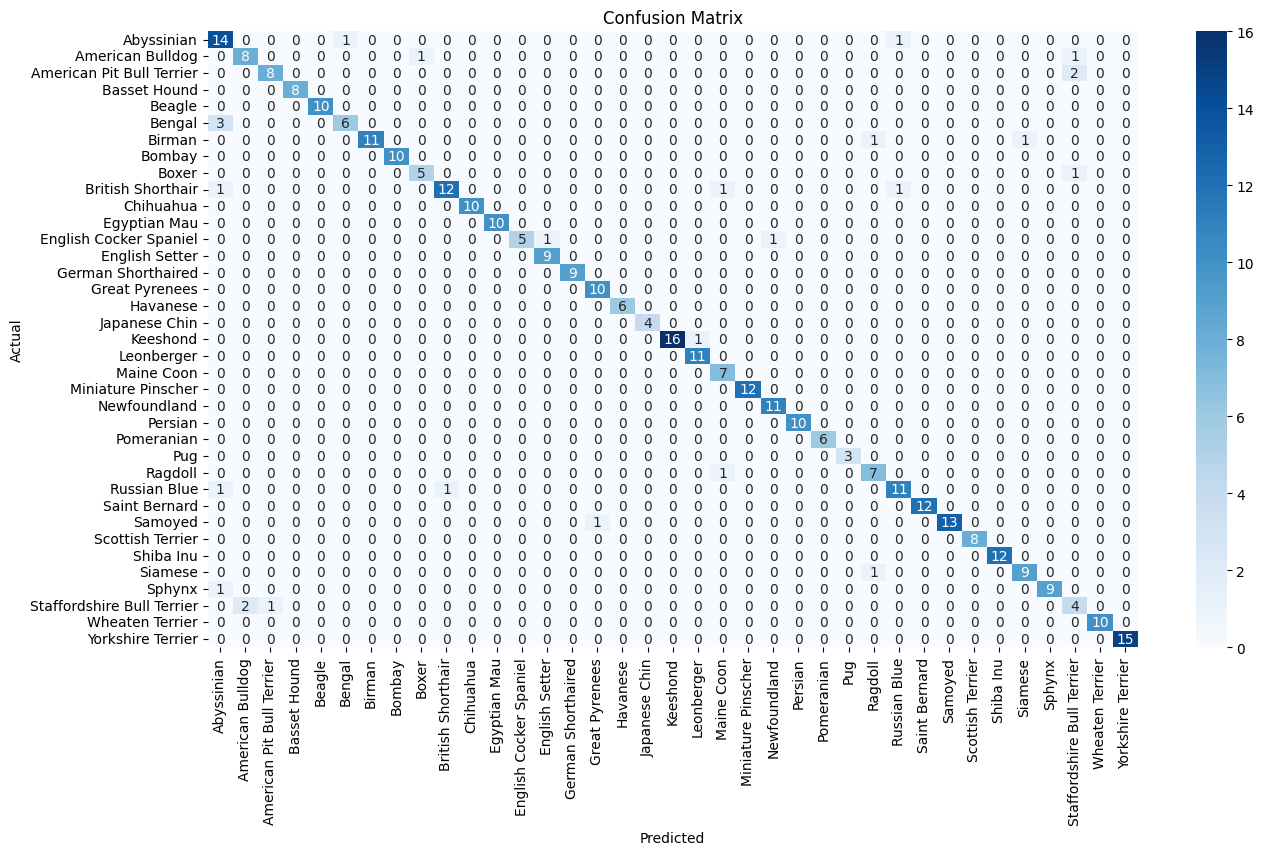

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
  for inputs, labels in test_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()